In [5]:
import pandas as pd
import numpy as np

# Grafik kütüphaneleri (ileride lazım olacak)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- VERİ YOLU TANIMLAMA ---
# Daha önce onayladığın tam yollar kullanıldı.
TAM_FAIZ_YOLU = r'C:\Users\ozlem\OneDrive\Masaüstü\turkiye-enflasyon-analizi\data\tcmb_faiz_oranlari.csv'
TAM_ENFLASYON_YOLU = r'C:\Users\ozlem\OneDrive\Masaüstü\turkiye-enflasyon-analizi\data\tcmb_enflasyon_verileri.txt'

# --- 1. FAİZ VERİSİ ---
df_faiz = pd.read_csv(TAM_FAIZ_YOLU, sep=';')
df_faiz = df_faiz.rename(columns={'Tarih': 'Tarih', 'Borç Verme': 'Politika_Faizi'})
df_faiz = df_faiz[['Tarih', 'Politika_Faizi']]
df_faiz['Tarih'] = pd.to_datetime(df_faiz['Tarih'], format='%d.%m.%Y', errors='coerce')
df_faiz['Politika_Faizi'] = pd.to_numeric(df_faiz['Politika_Faizi'], errors='coerce')
df_faiz.dropna(subset=['Tarih'], inplace=True)
df_faiz = df_faiz.sort_values(by='Tarih').reset_index(drop=True)


# --- 2. ENFLASYON VERİSİ ---
df_enflasyon = pd.read_csv(TAM_ENFLASYON_YOLU, 
                           sep='\s+', 
                           header=None,
                           skiprows=2,
                           names=['Tarih', 'Yillik_Degisim', 'Aylik_Degisim'])

for col in ['Yillik_Degisim', 'Aylik_Degisim']:
    df_enflasyon[col] = df_enflasyon[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df_enflasyon[col] = pd.to_numeric(df_enflasyon[col], errors='coerce')

df_enflasyon['Tarih'] = pd.to_datetime(df_enflasyon['Tarih'], format='%m-%Y', errors='coerce')
df_enflasyon = df_enflasyon.sort_values(by='Tarih').dropna(subset=['Tarih']).reset_index(drop=True)

# ÖNEMLİ DÜZELTME: Enflasyon değerlerini 100'e bölerek ondalık hale getiriyoruz
df_enflasyon['Yillik_Degisim'] = df_enflasyon['Yillik_Degisim'] / 100
df_enflasyon['Aylik_Degisim'] = df_enflasyon['Aylik_Degisim'] / 100


# --- 3. BİRLEŞTİRME VE DOLDURMA (df_birlesik'i Oluşturma) ---
df_birlesik = pd.merge(df_enflasyon, df_faiz, on='Tarih', how='left')

# Eksik faiz değerlerini, kendisinden önceki son geçerli değerle dolduruyoruz.
df_birlesik['Politika_Faizi'] = df_birlesik['Politika_Faizi'].ffill().bfill() 

print("✅ Tüm veri hazırlık adımları tamamlandı. 'df_birlesik' artık kullanıma hazır.")

✅ Tüm veri hazırlık adımları tamamlandı. 'df_birlesik' artık kullanıma hazır.


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ozlem\AppData\Local\Temp\ipykernel_20184\1378948104.py:24: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


✅ '../figures' klasörü oluşturuldu.


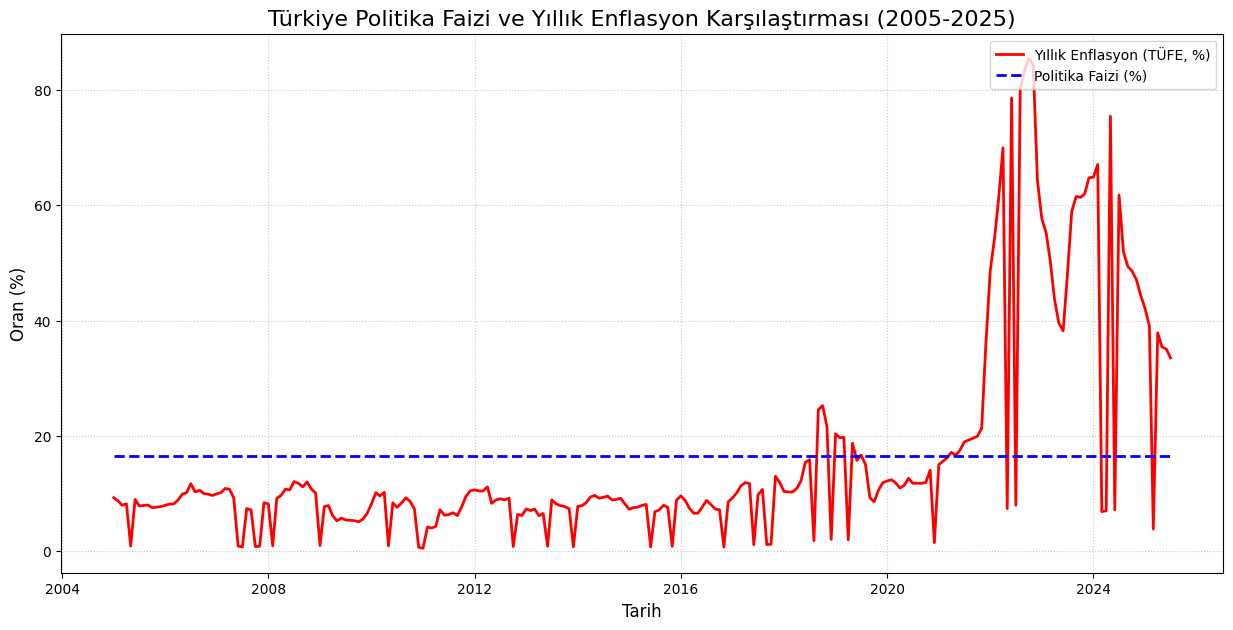

✅ Grafik Başarıyla Oluşturuldu ve proje tamamlandı.


In [9]:
import os

# 1. Klasör Kontrolü ve Oluşturma
# ../figures klasörünün var olup olmadığını kontrol eder. Yoksa oluşturur.
output_dir = '../figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"✅ '{output_dir}' klasörü oluşturuldu.")

# Grafiği çizmek için df_birlesik'i kullanıyoruz (df_birlesik hafızada olmalı)
df_gorsel = df_birlesik.set_index('Tarih')

plt.figure(figsize=(15, 7))

plt.plot(df_gorsel.index, df_gorsel['Yillik_Degisim'], label='Yıllık Enflasyon (TÜFE, %)', color='red', linewidth=2)
plt.plot(df_gorsel.index, df_gorsel['Politika_Faizi'], label='Politika Faizi (%)', color='blue', linestyle='--', linewidth=2)

plt.title('Türkiye Politika Faizi ve Yıllık Enflasyon Karşılaştırması (2005-2025)', fontsize=16)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Oran (%)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Kayıt yolu artık sorunsuz çalışacaktır.
plt.savefig(os.path.join(output_dir, 'faiz_enflasyon_karsilastirma.png'))

plt.show() 
print("✅ Grafik Başarıyla Oluşturuldu ve proje tamamlandı.")